In [3]:
from elm import ELM, ENRELM, score, score_orthogonal_directions
import numpy as np
import os
from sklearn.model_selection import train_test_split
import utils
from matplotlib import pyplot as plt
import time
import logger

# Esperimenti tutti i datasets sintetici

In [4]:
def syntetic_dataset_simulation(dataset_index):
    filename = f'dataset_{dataset_index}.csv'
    file_path = os.path.join('datasets/synthetic', filename)
    # Load the dataset from the CSV file
    dataset = np.loadtxt(file_path, delimiter=',')

    # Split the dataset into X and y
    X = dataset[:, :-1]
    y = dataset[:, -1]
    return single_dataset_simulation(X,y)


def single_dataset_simulation(X,y):
    seed_train_test_split = 1234

    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
    X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)

    #ENR-ELM
    time_ENRELM = time.time_ns()                                                                                    #start timing
    W, beta_U = ENRELM("erf", X_train, y_train, [-1*np.inf, np.inf], sort_by_correlation=False, threshold=0.9)      #run algorithm
    train_err_ENRELM = score_orthogonal_directions("erf", W, beta_U, X_train, y_train)                          #compute training error
    test_err_ENRELM = score_orthogonal_directions("erf", W, beta_U, X_test, y_test)                             #compute testing error
    time_ENRELM = (time.time_ns() - time_ENRELM)                                                                    #end timing
    time_ENRELM = time_ENRELM / 1e6                                                                                 #print timing
    print("ENRELM times:")
    print(f"{time_ENRELM:.3f} ms")


    #ELM
    hidden_space_dim = W.shape[1]  # W.shape[1] is the number of eigenvalues needed to exceed the threshold
    loops = 20
    loops_train_err_ELM = np.zeros(shape=(loops,hidden_space_dim))
    loops_test_err_ELM = np.zeros(shape=(loops,hidden_space_dim))

    time_ELM = time.time_ns()                                                                                       #start timing

    for loop in range(loops):
        for n in range(1,hidden_space_dim+1):
            W, beta, err = ELM(n, "erf", -1, X_train, y_train)
            loops_train_err_ELM[loop, n-1] = err
            loops_test_err_ELM[loop, n-1] = score("erf", W, beta, X_test, y_test)

    time_ELM = time.time_ns() - time_ELM                                                                            #end timing

    time_ELM_per_loop = round(time_ELM / loops) / 1e6
    time_ELM = time_ELM / 1e6
    
    print("ELM times:")
    print(f"{time_ELM:.3f} ms")
    print(f"{time_ELM_per_loop:.3f} ms per loop")


    train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
    min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
    max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
    test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
    min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
    max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)

    
    X_axis = np.arange(1, hidden_space_dim+1)
    
    return X_axis, train_err_ELM, train_err_ENRELM, test_err_ELM, test_err_ENRELM

In [5]:
import pandas as pd
def filter_csv(file_path, n0=None, X_distribution=None, X_range=None, 
               X_cov=None, X_rho=None, y_function=None, y_terms=None, y_SNR=None):
    # Read the CSV file
    df = pd.read_csv(file_path, sep=';')  # Assuming ';' is the delimiter 
    
    # Applying filters based on provided parameters
    filters = {
        'n0': n0,
        'X_distribution': X_distribution,
        'X_range': X_range,
        'X_cov': X_cov,
        'X_rho': X_rho,
        'y_function': y_function,
        'y_terms': y_terms,
        'y_SNR': y_SNR
    }
    
    # Remove None values from filters
    filters = {key: value for key, value in filters.items() if value is not None}
    #print(filters)
    # Filter the DataFrame
    for column, value in filters.items():
        print(column + "\t\t" + str(value))
        df = df[df[column] == value]

    if len(df['index'].tolist()) > 1:
        logger.error("Found more than one synthetic dataset matching filter, unable to identify a single dataset")
    elif len(df['index'].tolist()) == 0:
        logger.error("Found 0 synthetic dataset matching filter")

    # Return the index of the filtered rows
    return df['index'].tolist()

n0		100
X_distribution		uniform
X_cov		//
y_function		linear
y_SNR		2
ENRELM times:
37.128 ms
ELM times:
13345.150 ms
667.258 ms per loop
n0		100
X_distribution		gaussian
X_cov		iid
y_function		linear
y_SNR		2
ENRELM times:
14.961 ms
ELM times:
7915.439 ms
395.772 ms per loop
n0		100
X_distribution		gaussian
X_cov		toeplix
y_function		linear
y_SNR		2
ENRELM times:
13.962 ms
ELM times:
10972.125 ms
548.606 ms per loop
n0		100
X_distribution		uniform
X_cov		//
y_function		shallow
y_SNR		2
ENRELM times:
16.921 ms
ELM times:
12707.931 ms
635.397 ms per loop
n0		100
X_distribution		gaussian
X_cov		iid
y_function		shallow
y_SNR		2
ENRELM times:
47.872 ms
ELM times:
8790.642 ms
439.532 ms per loop
n0		100
X_distribution		gaussian
X_cov		toeplix
y_function		shallow
y_SNR		2
ENRELM times:
13.963 ms
ELM times:
8464.628 ms
423.231 ms per loop
n0		100
X_distribution		uniform
X_cov		//
y_function		linear
y_SNR		10
ENRELM times:
15.717 ms
ELM times:
9094.903 ms
454.745 ms per loop
n0		100
X_distribu

INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode


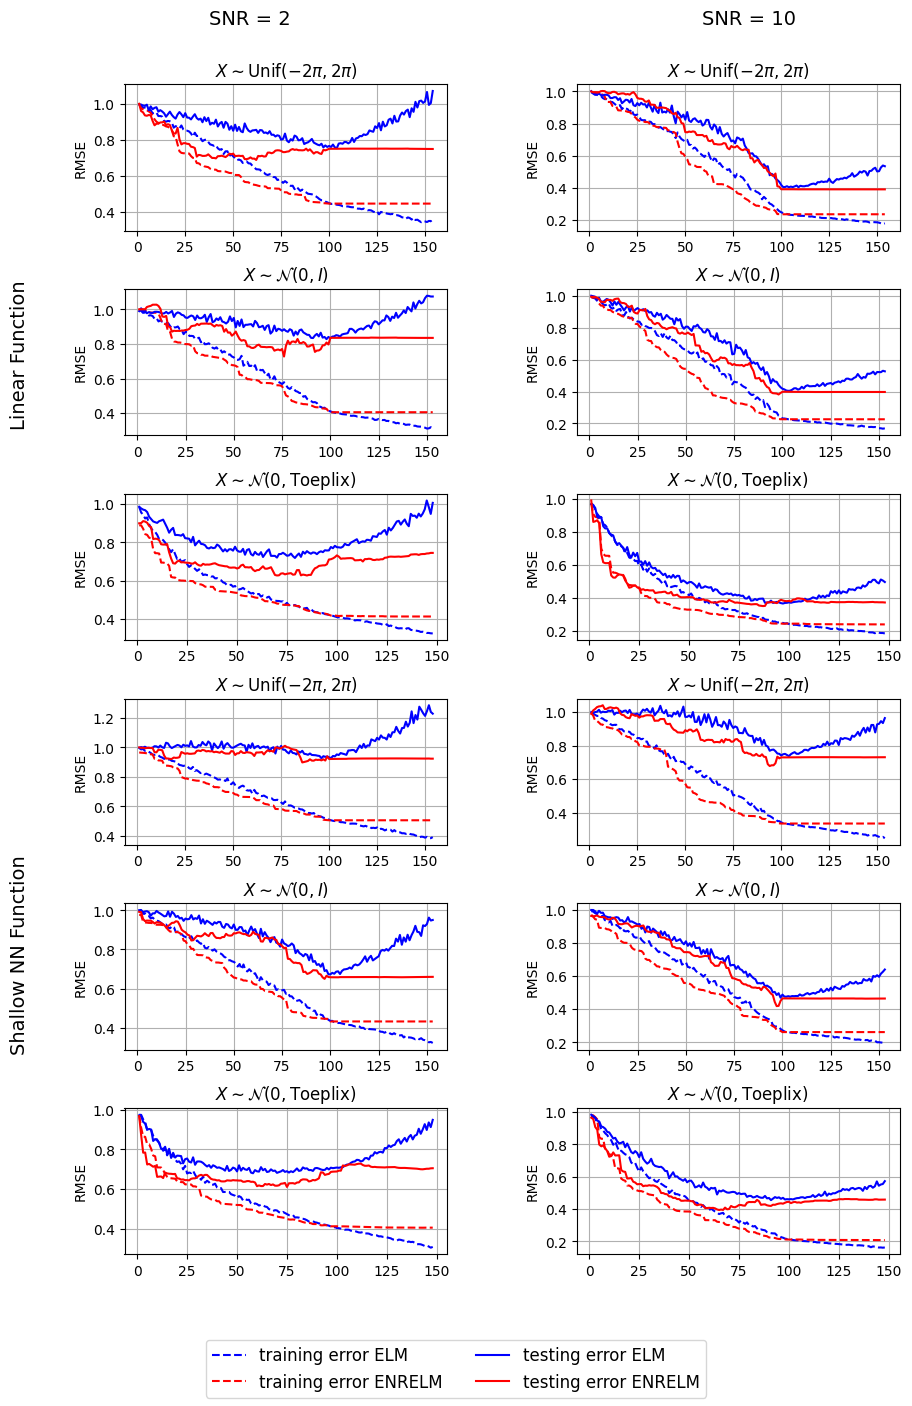

In [6]:
# Initialize figure and subplots
fig, axes = plt.subplots(6, 2, figsize=(10, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


# Define conditions
y_SNR_values = [2, 10]
y_functions = ["linear", "shallow"]
X_distributions = ["uniform", "gaussian"]
X_covs = ["iid", "toeplix"]
n0 = 100

# Titles for columns
column_titles = ["SNR = 2", "SNR = 10"]

# Add column titles
for i, title in enumerate(column_titles):
    fig.text(0.25 + i * 0.5, 0.92, title, ha='center', fontsize=14)

fig.text(0.02, 0.7, 'Linear Function', ha='center', va='center', rotation='vertical', fontsize=14)
fig.text(0.02, 0.3, 'Shallow NN Function', ha='center', va='center', rotation='vertical', fontsize=14)


# Iterate through each combination to place in the correct subplot
for i, y_SNR in enumerate(y_SNR_values):
    for j, y_function in enumerate(y_functions):
        for k, X_distribution in enumerate(X_distributions):
            if X_distribution == "uniform":
                row = 0
                X_cov = "//"
                title = r"$X \sim \text{Unif}(-2\pi, 2\pi)$"
                col = 0 if y_SNR == 2 else 1

                ax = axes[row + 3*j, col]

                dataset_index = filter_csv("synthetic_datasets_description.csv", n0, X_distribution, X_cov = X_cov, y_function= y_function, y_SNR=y_SNR)
                if len(dataset_index) != 1:
                    print(dataset_index)
                    print("Errore nella ricerca dell'indice del dataset")
                    exit()
                X_axis, train_err_ELM, train_err_ENRELM, test_err_ELM, test_err_ENRELM = syntetic_dataset_simulation(dataset_index[0])
                
                ax.plot(X_axis, train_err_ELM, 'b--', label='training error ELM')
                ax.plot(X_axis, train_err_ENRELM, 'r--', label='training error ENRELM')
                ax.plot(X_axis, test_err_ELM, 'b-', label='testing error ELM')
                ax.plot(X_axis, test_err_ENRELM, 'r-', label='testing error ENRELM')
                ax.set_title(title)
                #ax.set_ylim(0,2)
                ax.set_ylabel('RMSE')
                #ax.legend(loc='upper right')
                ax.grid(True)


            elif X_distribution == "gaussian":
                for l, X_cov in enumerate(X_covs):
                    if X_cov == "iid":
                        row = 1
                        title = r"$X \sim \mathcal{N}(0, I)$"
                    elif X_cov == "toeplix":
                        row = 2
                        title = r"$X \sim \mathcal{N}(0, \text{Toeplix})$"
                    col = 0 if y_SNR == 2 else 1

                    ax = axes[row + 3*j, col]

                    dataset_index = filter_csv("synthetic_datasets_description.csv", n0, X_distribution, X_cov = X_cov, y_function= y_function, y_SNR=y_SNR)
                    if len(dataset_index) != 1:
                        print(dataset_index)
                        print("Errore nella ricerca dell'indice del dataset")
                        exit()
                    X_axis, train_err_ELM, train_err_ENRELM, test_err_ELM, test_err_ENRELM = syntetic_dataset_simulation(dataset_index[0])
                    
                    ax.plot(X_axis, train_err_ELM, 'b--', label='training error ELM')
                    ax.plot(X_axis, train_err_ENRELM, 'r--', label='training error ENRELM')
                    ax.plot(X_axis, test_err_ELM, 'b-', label='testing error ELM')
                    ax.plot(X_axis, test_err_ENRELM, 'r-', label='testing error ENRELM')
                    ax.set_title(title)
                    #ax.set_ylim(0,2)
                    ax.set_ylabel('RMSE')
                    #ax.legend(loc='upper right')
                    ax.grid(True)
            
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=12)
# Adjust layout to make space for the legend
plt.subplots_adjust(bottom=0.1)
# Show plot
plt.show()

Abalone
ENRELM times:
9573.200 ms
ELM times:
76.794 ms
3.840 ms per loop
<class 'pandas.core.frame.DataFrame'>
Auto MPG
ENRELM times:
24.933 ms
ELM times:
264.293 ms
13.215 ms per loop
Bank
ENRELM times:
49095.021 ms
ELM times:
10851.549 ms
542.577 ms per loop
California Housing
ENRELM times:
688129.395 ms
ELM times:
465.756 ms
23.288 ms per loop
Delta Ailerons
ENRELM times:
31033.978 ms
ELM times:
106.752 ms
5.338 ms per loop
LA Ozone
ENRELM times:
17.755 ms
ELM times:
100.624 ms
5.031 ms per loop
Machine CPU
ENRELM times:
5.984 ms
ELM times:
12.966 ms
0.648 ms per loop
Prostate Cancer
ENRELM times:
1.995 ms
ELM times:
36.901 ms
1.845 ms per loop
Servo
ENRELM times:
6.981 ms
ELM times:
609.330 ms
30.466 ms per loop


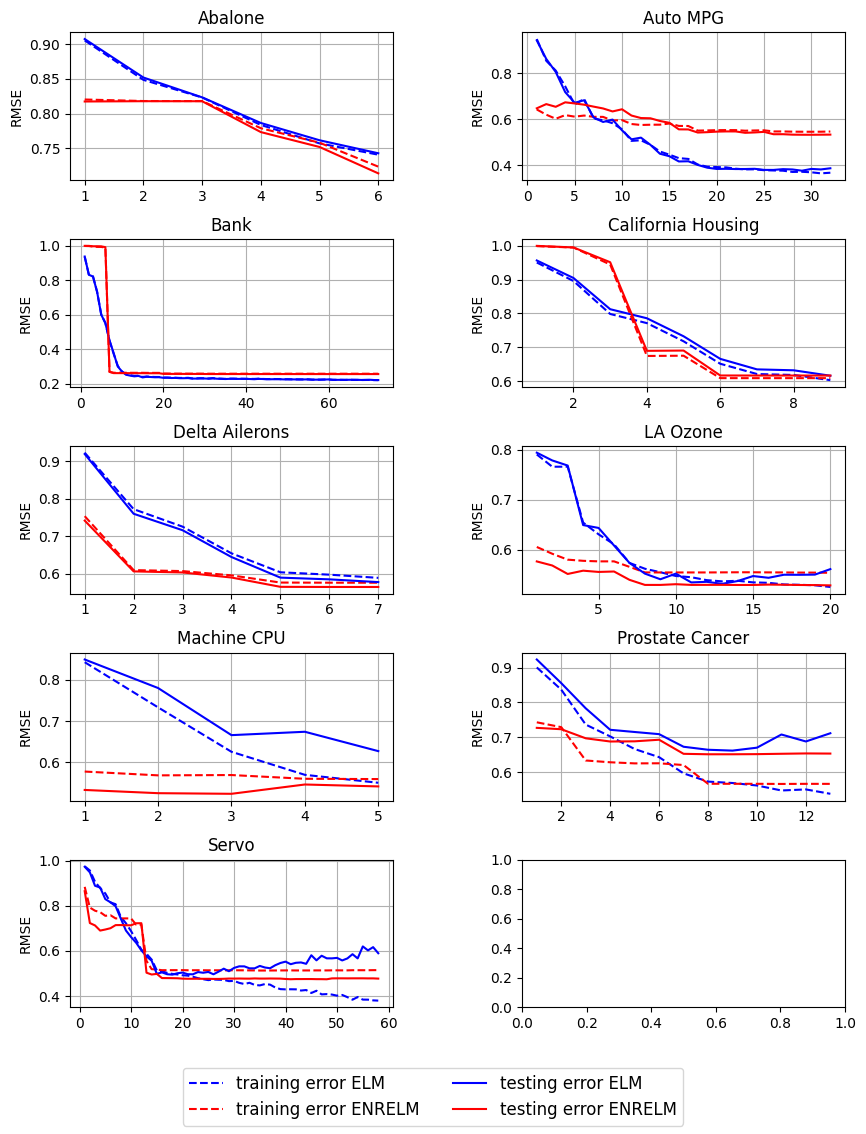

In [7]:
import datagenerator
import dataloader

# Initialize figure and subplots
fig, axes = plt.subplots(5, 2, figsize=(10, 12.5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

loaders = {
    1: ("Abalone", dataloader.load_abalone),
    2: ("Auto MPG", dataloader.load_auto_mpg),
    3: ("Bank", dataloader.load_bank),
    4: ("California Housing", dataloader.load_california_housing),
    5: ("Delta Ailerons", dataloader.load_delta_ailerons),
    6: ("LA Ozone", dataloader.load_LAozone),
    7: ("Machine CPU", dataloader.load_machine_cpu),
    8: ("Prostate Cancer", dataloader.load_prostate),
    9: ("Servo", dataloader.load_servo)
}

# Iterate through each combination to place in the correct subplot
for key, value in loaders.items():
                ax = axes[(key-1)//2, (key-1)%2]
                name = value[0]
                loader = value[1]
                generator = datagenerator.LoaderDataGenerator(name, loader)
                res = generator.generate()
                print(res['name'])
                X = res['data'][0]
                y = res['data'][1]

                X_axis, train_err_ELM, train_err_ENRELM, test_err_ELM, test_err_ENRELM = single_dataset_simulation(X,y)
                
                ax.plot(X_axis, train_err_ELM, 'b--', label='training error ELM')
                ax.plot(X_axis, train_err_ENRELM, 'r--', label='training error ENRELM')
                ax.plot(X_axis, test_err_ELM, 'b-', label='testing error ELM')
                ax.plot(X_axis, test_err_ENRELM, 'r-', label='testing error ENRELM')
                ax.set_title(name)
                #ax.set_ylim(0,2)
                ax.set_ylabel('RMSE')
                #ax.legend(loc='upper right')
                ax.grid(True)

            
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=12)
# Adjust layout to make space for the legend
plt.subplots_adjust(bottom=0.1)
# Show plot
plt.show()